# 1 Initialize Project

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras import backend as K

from utils import plots, get_batches, get_data
from dataset import train_test_split, partition_file

Using Theano backend.
Using cuDNN version 5110 on context None
Preallocating 6553/8192 Mb (0.800000) on cuda0
Mapped name None to device cuda0: GeForce GTX 1080 (0000:01:00.0)


In [4]:
PATH="data/"
sz=224
batch_size=64

In [5]:
!dir "{PATH}"

 Volume in drive C has no label.
 Volume Serial Number is EAA3-77E8

 Directory of C:\DEV\dogbreeds\model\data

2018-02-07  08:26 PM    <DIR>          .
2018-02-07  08:26 PM    <DIR>          ..
2018-02-08  07:52 PM    <DIR>          dogbreeds
2018-02-05  07:51 PM           482,063 labels.csv
               1 File(s)        482,063 bytes
               3 Dir(s)  1,866,677,329,920 bytes free


In [6]:
label_csv = f'{PATH}labels.csv'

# 2 Explore Data

In [7]:
label_df = pd.read_csv(label_csv)

In [8]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Classes with the most amount of data

In [10]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False).head(12)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


Dog breeds with least amount of pictures

In [11]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False).tail(12)

,id
breed,
french_bulldog,70
vizsla,70
tibetan_mastiff,69
german_shepherd,69
giant_schnauzer,69
walker_hound,69
otterhound,69
golden_retriever,67
brabancon_griffon,67


Note that we have atleast 120 different dog breeds with atleast 66 images per breed. This is a fairly small size to train off of

# 3 Preprocess Data

Get a dictionary mapping of ids to breeds

In [12]:
breed_id = {row['id']:row['breed'] for i, row in label_df.iterrows()}

In [25]:
# todo: call the partition code to move images into keras style file structure
# dataset.partition_file(file_map=breed_id, path=data_folder)

Configure data:

In [13]:
train_folder = PATH + "dogbreeds/train/"
test_size=0.2

In [38]:
train_test_split(breed_id, 
                 in_path_list=[train_folder + "train", train_folder + "valid"], 
                 dest_path=train_folder, 
                 test_size=test_size)

In [14]:
val_batches = get_batches(train_folder + "valid", shuffle=False, batch_size=1)
batches = get_batches(train_folder + "train", shuffle=False, batch_size=1)

Found 2044 images belonging to 120 classes.
Found 8178 images belonging to 120 classes.


In [29]:
val_data = get_data(train_folder + "valid")
trn_data = get_data(train_folder + "train")

Found 2044 images belonging to 120 classes.
Found 8178 images belonging to 120 classes.


In [17]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [30]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

# 4 Fit Model

In [31]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

C:\DEV\dogbreeds\model\vgg16.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
C:\DEV\dogbreeds\model\vgg16.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
C:\DEV\dogbreeds\model\vgg16.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
C:\DEV\dogbreeds\model\vgg16.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
C:\DEV\dogbreeds\model\vgg16.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))


In [32]:
vgg.finetune(batches)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [33]:
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(val_batches.n/batch_size))

In [170]:
model.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=8, validation_data=val_batches, validation_steps=validation_steps)

Epoch 1/8
8178/128 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 6/8
8178/128 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [172]:
model.save_weights(PATH + 'dogbreedft.h5')

# Viewing Model Predictions
Lets explore how the model performed over the the validation set by seeing examples where the model:
1. Predicted the correct label
2. Predicted an incorrect label
3. Most Correct labels of a few classes
4. Most Incorrect labels of a few classes
5. Most Uncertain labels of a few classes

In [240]:
prob = model.predict(val_data, batch_size=batch_size)

In [189]:
n_preview = 4
filenames = val_batches.filenames

In [191]:
def plots_idx(idx, titles=None):
    plots([image.load_img(train_folder + 'valid/' + filenames[i]) for i in idx], titles=titles)

In [259]:
# get onehot encoded class prediction
pred = np.zeros(prob.shape)
class_idx = prob.argmax(axis=-1)
for i in range(len(class_idx)):
    pred[i, class_idx[i]]=1
    
np.array_equal(pred, val_labels)

False

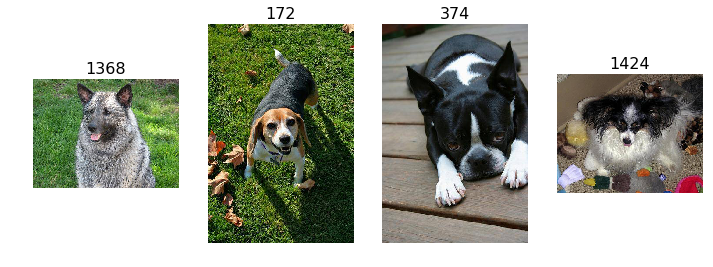

In [281]:
# 1. Predicted correct label
correct = np.where(np.all(np.equal(pred,val_labels),axis=1))[0]
idx = np.random.permutation(correct)[:n_preview]
plots_idx(idx, idx)


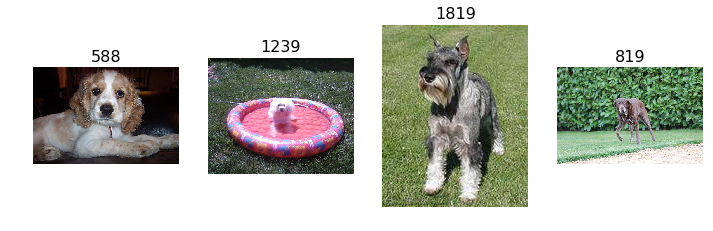

In [286]:
# 2. Predicted incorrect labels
in_correct = np.where(np.any(np.not_equal(pred,val_labels),axis=1))[0]
idx = np.random.permutation(in_correct)[:n_preview]
plots_idx(idx, idx)


# Create Kaggle Submission

In [70]:
test_folder = PATH + "dogbreeds/test"
test_batch = get_data(test_folder)

Found 0 images belonging to 0 classes.


ValueError: need at least one array to concatenate